#### 점진적 증가와 단계적 업스케일링, Progressive Growing

In [6]:
import tensorflow as tf
import tensorflow.keras as K

In [2]:
def upscale_layer(layer, upscale_factor):
    '''
    upscale_factor(int)만큼 층(텐서)을 업스케일합니다.
    텐서 크기는 [group, height, width, channels] 입니다.
    '''
    height, width = layer.get_shape()[1:3]
    size = (upscale_factor * height, upscale_factor * width)
    upscaled_layer = tf.image.resize_nearest_neighbor(layer, size)
    return upscaled_layer

In [3]:
def smoothly_merge_last_layer(list_of_layers, alpha):
    '''
    임계값 알파를 기반으로 층을 부드럽게 합칩니다.
    이 함수는 모든 층이 이미 RGB로 바뀌었다고 가정합니다.
    생성자를 위한 함수입니다.
    :list_of_layers : 해상도(크기) 순서대로 정렬된 텐서 리스트
    :alpha          : (0, 1) 사이의 실수
    '''

    # 업스케일링을 위해 끝에서 두 번째 층을 선택합니다.
    last_fully_trained_layer = list_of_layers[-2]
    # 마지막으로 훈련된 층을 업스케일링합니다.
    last_layer_upscaled = upscale_layer(last_fully_trained_layer, 2)

    # 새로 추가된 층은 아직 완전히 훈련되지 않았습니다.
    larger_native_layer = list_of_layers[-1]

    # 합치기 전에 층 크기가 같은지 확인합니다.
    assert larger_native_layer.get_shape() == last_layer_upscaled.get_shape()

    # 곱셈은 브로드캐스팅되어 수행합니다.
    new_layer = (1 - alpha) * last_layer_upscaled + larger_native_layer * alpha

    return new_layer

#### 미니배치 표준편차, mini-batch standard deviation

In [4]:
def minibatch_std_layer(layer, gropu_size=4):
    '''
    층의 미니배치 표준편차를 계산합니다.
    층의 데이터 타입은 float32로 가정합니다. 그렇지 않으면 타입 변환이 필요합니다.
    '''

    # 미니배치는 group_size로 나눌 수 있거나 group_size보다 같거나 작아야 합니다.
    group_size = K.backend.minimun(gropu_size, tf.shape(layer)[0])
    # 간단하게 쓰기 위해 크기 정보를 따로 저장합니다. 
    # 그래프 실행 전에는 일반적으로 배치 차원이 None이기 때문에 tf.shape에서 이 크기를 얻습니다.
    shape = list(K.int_shape(input))
    shape[0] = tf.shape(input)[0]
    # 미니배치 수준에서 연산하기 위해 크기를 바꿉니다.
    # 이 코드는 층이 [그룹(G), 미니배치(M), 너비(W), 높이(H), 채널(C)]라고 가정합니다.
    # 하지만 시애노 방식의 순서를 사용하는 구현도 있습니다.
    minibatch = K.backend.reshape(layer, 
        (group_size, -1, shape[1], shape[2], shape[3]))
    # [M, W, H, C] 그룹의 평균을 계산합니다.
    minibatch -= tf.reduce_mean(minibatch, axis=0, keepdims=True)
    # [M, W, H, C] 그룹의 분산을 계산합니다.
    minibatch = tf.reduce_mean(K.backend.square(minibatch), axis=0)
    # [M, W, H, C] 그룹의 표준편차를 계산합니다.
    minibatch = K.backend.square(minibatch + 1e-8)
    # 특성 맵을 평균화하여 [M, 1, 1, 1] 픽셀을 얻습니다.
    minibatch = tf.reduce_mean(minibatch, axis=[1, 2, 3], keepdims=True)

    # 스칼라 값을 그룹과 픽셀에 맞게 변환합니다.
    minibatch = K.backend.tile(minibatch, 
        [group_size, 1, shape[2], shape[3]])
    # 새로운 특성 맵을 추가합니다.
    return K.backend.concatenate([layer, minibatch], axis=1)

#### 균등 학습률, equalized learning rate

In [7]:
import numpy as np
def equalize_learning_rate(shape, gain, fan_in=None):
    '''
    He 초기화의 상수로 모든 층의 가중치를 조정하여
    특성마다 각기 다른 다이내믹 레인지를 가지도록 분산을 맞춥니다.
    shape   :   텐서(층)의 크기: 각 층의 차원입니다.
        예를 들어, [4, 4, 48, 3]. 이 경우 [커널 크기, 커널 크기, 필터 개수, 특성맵]입니다.
        하지만 구현에 따라 조금 다를 수 있습니다.
    gain    :   일반적으로 sqrt(2)
    fan_in  :   세이비어/He 초기화에서 입력 연결 개수
    '''

    # 기본 값은 특성 맵 차원을 제외하고 shape의 모든 차원을 곱합니다.
    # 이를 통해 뉴런마다 입력 연결 개수를 얻습니다.
    if fan_in is None: fan_in = np.prod(shape[:-1])
    # He 초기화 상수
    std = gain / K.sqrt(fan_in)
    # 조정을 위한 상수를 만듭니다.
    wscale = K.constant(std, name='wscale', dtype=np.float32)
    # 가중치 값을 얻어 브로드캐스팅으로 wscale을 적용합니다.
    adjusted_weights = K.get_value('layer', shape=shape,
            initializer=tf.initializers.random_normal()) * wscale
    return adjusted_weights

#### 픽셀별 특성 정규화

In [8]:
def pixelwise_feat_norm(inputs, **kwargs):
    '''
    크리젭스키와 연구진이 2012년 논문에 제안한 픽셀별 특성 정규화
    :inputs :   케라스 / TF 층
    '''
    normalization_constant = K.backend.sqrt(K.backend.mean(
                inputs ** 2, axis=-1, keepdims=True) + 1.0e-8)
    return inputs / normalization_constant

#### TFHub 실습

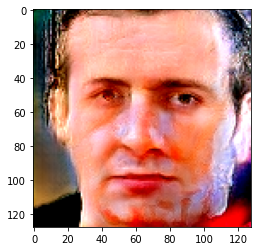

In [9]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

# TFHub에서 ProGAN을 임포트합니다.
module = hub.KerasLayer('https://tfhub.dev/google/progan-128/1')
# 생성할 샘플의 잠재 공간 차원
latent_dim = 512

# 시드를 바꾸면 다른 얼굴을 생성합니다.
latent_vector = tf.random.normal([1, latent_dim], seed=1337)

# 모듈을 사용해 잠재 공간에서 이미지를 생성합니다.
interpolated_images = module(latent_vector)

plt.imshow(interpolated_images.numpy().reshape(128, 128, 3))
plt.show()

In [10]:
from absl import logging
import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import time
from IPython import display
from skimage import transform

# 어떤 모델을 사용할지 사전에 모른다면
# module.get_input_shapes()로 값을 얻을 수 있다.
latent_dim = 512

# 0이 아니고 원점을 통과하는 직선에 놓여 있지 않는 두 벡터 사이를 보간
# 먼저 v2를 정규화하여 v1과 같은 노름(norm)을 가지도록 만든다.
# 그 다음 초구(hypersphere)에 있는 두 벡터 사이를 보간한다.
def interpolate_hypersphere(v1, v2, num_steps):
    v1_norm = tf.norm(v1)
    v2_norm = tf.norm(v2)
    v2_normalized = v2 * (v1_norm / v2_norm)

    vectors = []
    for step in range(num_steps):
        interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
        interpolated_norm = tf.norm(interpolated)
        interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
        vectors.append(interpolated_normalized)
    return tf.stack(vectors)

# 일련의 이미지에서 애니메이션을 만든다.
def animate(images):
    images = np.array(images)
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images)
    with open('./animation.gif', 'rb') as f:
        display.display(display.Image(data=f.read(), height=300))

# 간단한 이미지를 출력
def display_image(image):
    plt.figure()
    plt.axis('off')
    plt.imshow(image)

# 여러 개의 이미지를 하나의 그림으로 출력
def display_images(images, captions=None):
    num_horizontally = 5
    f, axes = plt.subplots(
        len(images) // num_horizontally, num_horizontally, figsize=(20, 20))
    for i in range(len(images)):
        axes[i // num_horizontally, i % num_horizontally].axis('off')
        if captions is not None:
            axes[i // num_horizontally, i % num_horizontally].text(0, -3, captions[i])
        axes[i // num_horizontally, i % num_horizontally].imshow(images[i])
    f.tight_layout()

logging.set_verbosity(logging.ERROR)

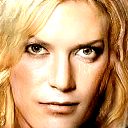

In [11]:
def interpolate_between_vectors():
    module = hub.KerasLayer('https://tfhub.dev/google/progan-128/1')

    v1 = tf.random.normal([latent_dim], seed=3)
    v2 = tf.random.normal([latent_dim], seed=1)

    # v1과 v2 사이 25개의 스텝을 담은 보간 텐서를 만든다.
    vectors = interpolate_hypersphere(v1, v2, 25)

    # 모듈을 사용해 잠재 공간에서 이미지를 생성
    interpolated_images = module(vectors)

    animate(interpolated_images)

interpolate_between_vectors()

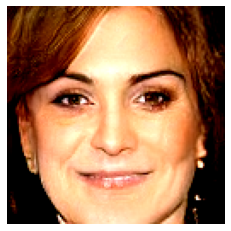

In [13]:
image_from_module_space = True

def get_module_space_image():
    module = hub.KerasLayer('https://tfhub.dev/google/progan-128/1')
    vector = tf.random.normal([1, latent_dim], seed=4)
    images = module(vector)
    return images[0]

def upload_image():
    uploaded = files.upload()
    image = imageio.imread(uploaded[uploaded.keys()[0]])
    return transform.resize(image, [128, 128])

if image_from_module_space:
    target_image = get_module_space_image()
else:
    target_image = upload_image()
display_image(target_image)

In [19]:
def find_closest_latent_vector(num_optimization_steps, steps_per_image):
    images = []
    losses = []
    module = hub.KerasLayer('https://tfhub.dev/google/progan-128/1')

    initial_vector = tf.random.normal([1, latent_dim], seed=5)

    vector = tf.Variable(initial_vector)
    optimizer = tf.optimizers.Adam(learning_rate=0.01)
    loss_fn = tf.losses.MeanAbsoluteError(reduction='sum')

    for step in range(num_optimization_steps):
        if (step % 100) == 0:
            print()
        print('.', end='')
        with tf.GradientTape() as tape:
            image = module(vector.read_value())
            if (step % steps_per_image) == 0:
                images.append(image.numpy().reshape(128, 128, 3))
            target_image_difference = loss_fn(image, target_image[:,:,:3])
            # 잠재 벡터는 정규 분포에서 샘플링하였다.
            # 잠재 벡터의 길이를 이 분포에서 얻은 벡터의 평균 길이로 제한하면
            # 더 실제 같은 이미지를 얻을 수 있다.
            regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))

            loss = target_image_difference + regularizer
            losses.append(loss.numpy())
        grads = tape.gradient(loss, [vector])
        optimizer.apply_gradients(zip(grads, [vector]))

    return images, losses

result = find_closest_latent_vector(num_optimization_steps=200, steps_per_image=5)


....................................................................................................
....................................................................................................

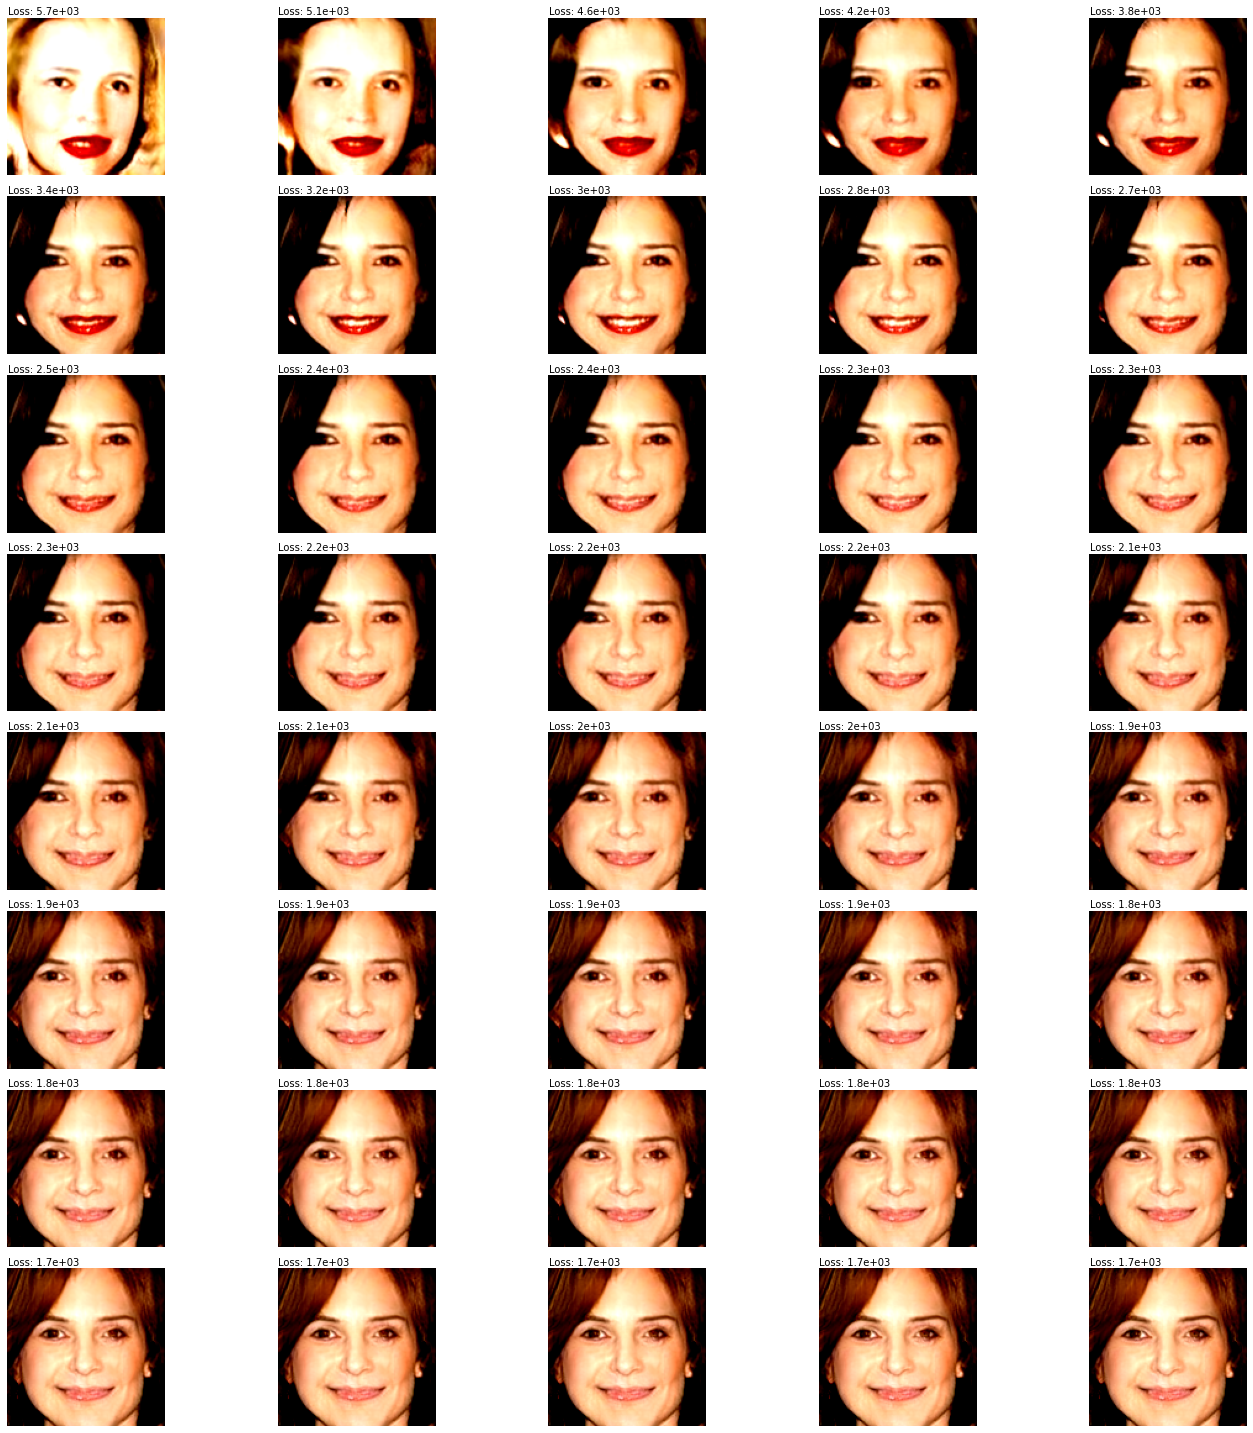

In [20]:
captions = [f'Loss: {l:.2}' for l in result[1]]
display_images(result[0], captions)